In [1]:
import pickle as pk
import numpy as np
from glob import glob

In [3]:
data_dir="/dev/shm/data/patches"
!ls -lrt $data_dir/ | head

total 50187380
-rw-rw-r-- 1 ubuntu ubuntu 1447758130 Oct  9 21:42 patches0.npz
-rw-rw-r-- 1 ubuntu ubuntu 1291505818 Oct  9 21:43 patches1.npz
-rw-rw-r-- 1 ubuntu ubuntu 1138911362 Oct  9 21:44 patches2.npz
-rw-rw-r-- 1 ubuntu ubuntu 1084877298 Oct  9 21:44 patches3.npz
-rw-rw-r-- 1 ubuntu ubuntu 1200516650 Oct  9 21:45 patches4.npz
-rw-rw-r-- 1 ubuntu ubuntu 1220419690 Oct  9 21:45 patches5.npz
-rw-rw-r-- 1 ubuntu ubuntu 1128785018 Oct  9 21:46 patches6.npz
-rw-rw-r-- 1 ubuntu ubuntu 1534161530 Oct  9 21:47 patches7.npz
-rw-rw-r-- 1 ubuntu ubuntu 1261879874 Oct  9 21:48 patches8.npz


In [508]:
patches=[]
filenames=glob(data_dir+'/patches*.npz')
for file in filenames[:4]:
    print(file)
    content=np.load(file)
    patches.append(content['Vout'])

/dev/shm/data/patches/patches9.npz
/dev/shm/data/patches/patches7.npz
/dev/shm/data/patches/patches8.npz
/dev/shm/data/patches/patches5.npz


In [509]:
combined=np.concatenate(patches)
combined.size/1000000.

661.149067

In [510]:
def permute(data):
    shuffle=np.random.permutation(data.shape[0])
    return data[shuffle,:,:]
scombined=permute(combined)
scombined.shape

(393307, 41, 41)

In [511]:
%pylab inline

Populating the interactive namespace from numpy and matplotlib


/home/ubuntu/.local/lib/python3.5/site-packages/IPython/core/magics/pylab.py:160: UserWarning: pylab import has clobbered these variables: ['diff', 'entropy', 'size', 'convolve']
`%matplotlib` prevents importing * from pylab and numpy
  "\n`%matplotlib` prevents importing * from pylab and numpy"


In [512]:
import matplotlib.pyplot as plt
from astropy.convolution import Gaussian2DKernel,convolve
gaussian = Gaussian2DKernel(1,x_size=7,y_size=7)
factor=sum(gaussian)
print('factor=',factor)
def calc_err(pic):
    P=convolve(pic,gaussian)/factor
    error=sqrt(mean(abs(pic-P)))
    sub=P[::2,::2]
    return error,sub

factor= 0.9994587918263369


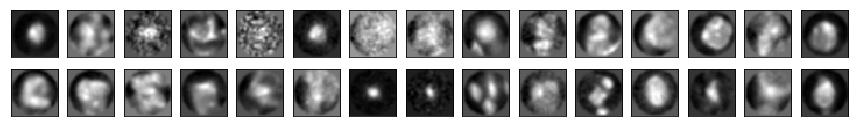

In [513]:
def plot_patches(data,h=40,w=15):
    figure(figsize=(w,h))
    for i in range(h*w):
        if i>=data.shape[0]:
            break
        subplot(h,w,i+1);
        pic=data[i,:,:]
        P=convolve(pic,gaussian)/factor

        fig=imshow(P,cmap='gray')
        fig.axes.get_xaxis().set_visible(False)
        fig.axes.get_yaxis().set_visible(False)
plot_patches(scombined,h=2)

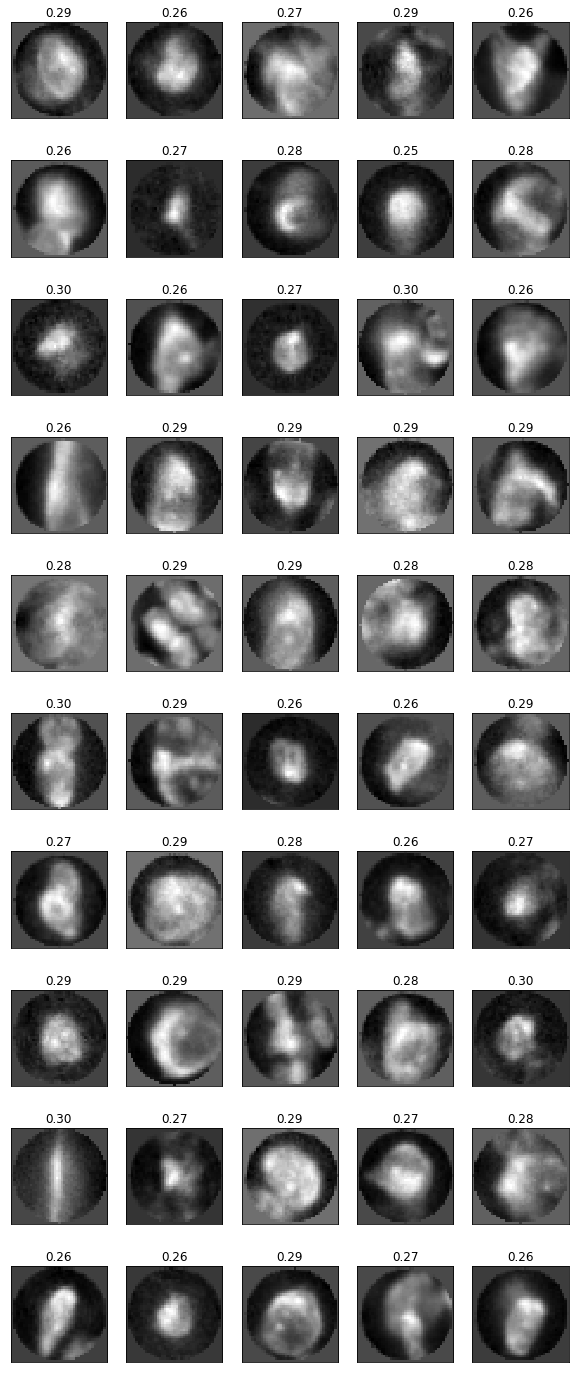

In [514]:
h=10
w=5
shift=1000
figure(figsize=(2*w,2.5*h))

i=0; j=0;
while j < h*w:
    pic=scombined[i+shift,:,:]
    i+=1
    error,sub=calc_err(pic)
    if error>0.3:
        continue
    subplot(h,w,j+1);
    j+=1
    fig=imshow(pic,cmap='gray')
    plt.title('%4.2f'%error);
    fig.axes.get_xaxis().set_visible(False)
    fig.axes.get_yaxis().set_visible(False)

In [515]:
shift

1000

In [517]:
#collect images that are pretty smooth
# reduce resolution by a factor of 2
low_err=[]
i=0
while len(low_err) <1000000:
    if i >= scombined.shape[0]:
        break
    pic=scombined[i,:,:]
    i+=1
    error,sub=calc_err(pic)
    if error<0.3:
        low_err.append(sub)
        j=len(low_err)
        if j%1000==0:
            print('\r',i,j,end='')

lcombined=np.stack(low_err)
lcombined.shape

 392809 127000

(127173, 21, 21)

In [518]:
def dist2(a,b):
    diff=(a-b)**2
    return sum(diff.flatten())

In [519]:
D=[]
for i in range(1,lcombined.shape[0]):
    D.append(dist2(lcombined[i,:,:],lcombined[i-1,:,:]))
    if i%1000==0:
        print('\r',i,end='')

 127000

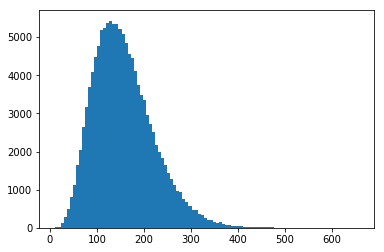

In [520]:
hist(D,bins=100);

In [521]:
max(D)

657.34342181938

In [522]:
lcombined.shape

(127173, 21, 21)

In [88]:
def Kmeanspp(data,n=100,scale=550):
    Reps=[data[0,:,:]]

    Statistics=[]
    j=1
    for i in range(1,data.shape[0]): #scombined.shape[0]):
        _min=100000
        patch=data[i,:,:]
        for r in Reps:
            _min=min(_min,dist2(patch,r))
        Prob=_min/scale
        print('\r','i=%10d,  #reps=%10d  Prob=%8.6f'%(i,len(Reps),Prob),end='')
        Statistics.append((i,len(Reps),_min))
        if np.random.rand()<Prob:
            Reps.append(patch)
            j+=1
        if j>=n:
            break
    return Reps,Statistics

In [89]:
def plot_statistics(Statistics,alpha=0.05,_start=10): 
    N=[x[1] for x in Statistics]
    d=[x[2] for x in Statistics]

    s=mean(d[:_start])
    smoothed=[s]*_start
    for x in d[_start:]:
        s=(1-alpha)*s + alpha*x
        smoothed.append(s)
    loglog(N[_start:],smoothed[_start:])
    xlabel('N')
    ylabel('smoothed distance')
    grid(which='both')

partition 0
 i=         5,  #reps=         2  Prob=0.178247partition 1
 i=         5,  #reps=         2  Prob=0.367607partition 2
 i=         6,  #reps=         2  Prob=0.329917partition 3
 i=        18,  #reps=         2  Prob=0.137352partition 4
 i=         5,  #reps=         2  Prob=0.226485partition 5
 i=        14,  #reps=         2  Prob=0.104101partition 6
 i=         6,  #reps=         2  Prob=0.305531partition 7
 i=        12,  #reps=         2  Prob=0.296602partition 8
 i=         2,  #reps=         2  Prob=0.366757partition 9
 i=        12,  #reps=         2  Prob=0.376369partition 10
 i=         9,  #reps=         2  Prob=0.383478partition 11
 i=         6,  #reps=         2  Prob=0.165456partition 12
 i=         4,  #reps=         2  Prob=0.355028partition 13
 i=         7,  #reps=         2  Prob=0.287166partition 14
 i=         5,  #reps=         2  Prob=0.182612partition 15
 i=         5,  #reps=         2  Prob=0.220923partition 16
 i=         4,  #reps=         2  Pro

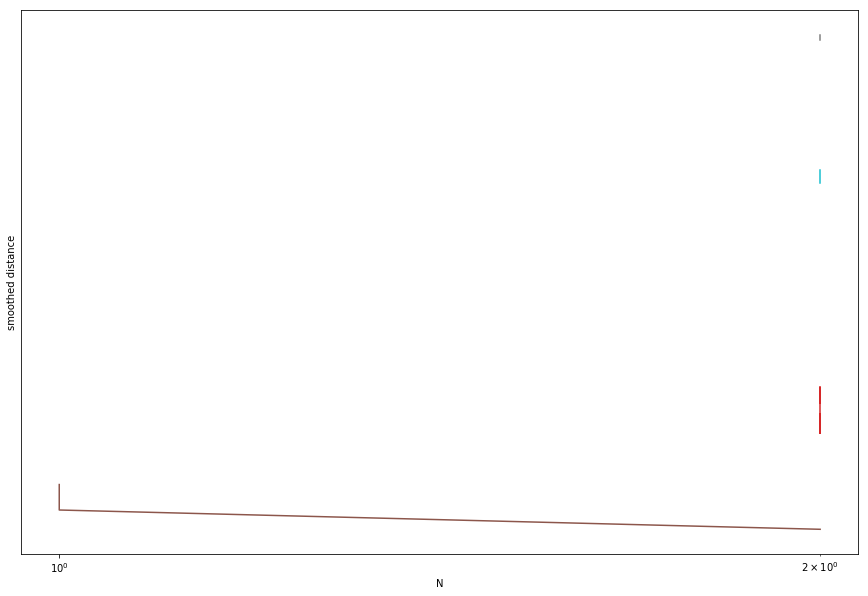

In [583]:
# Generate K different partitions

K=20 # number of independent partitions
N =3 # number of parts in each partition
Multi_Rep=[]
figure(figsize=[15,10])
for i in range(K):
    print('partition',i)
    lcombined=permute(lcombined)
    Reps, Statistics = Kmeanspp(lcombined,n=N)
    Multi_Rep.append(Reps)
    plot_statistics(Statistics)


In [584]:
len(Multi_Rep)

20

In [585]:
lcombined.shape

(127173, 21, 21)

In [586]:
stacks=[]
for Rep in Multi_Rep:
    stacks.append(np.stack(Rep))
All=np.stack(stacks)
All.shape

(20, 3, 21, 21)

In [587]:
pic=np.zeros([1,1,21,21])

all_labels=[]

mean_vecs=np.zeros([])
for i in range(lcombined.shape[0]):
    pic[0,0,:,:]=lcombined[i,:,:]

    diff=(All-pic)**2
    dists=np.sum(np.sum(diff,axis=2),axis=2)
    labels=np.argmin(dists,axis=1)
    all_labels.append(tuple(labels))
    if i%1000==0:
        print('\r',i,end='')

 127000

In [588]:
len(all_labels[0])

20

In [589]:
from collections import Counter

def calc_entropy(all_labels,i=0,j=1,threshold=1):
    c=Counter([x[i:j] for x in all_labels])
    counts=np.array(list(c.values()),dtype=np.float)
    counts1=counts[counts>threshold]
    leftout=sum(counts)-sum(counts1)
    if leftout>0:
        counts1=np.concatenate([np.array([leftout]),counts1])
    P=counts1/sum(counts1)
    return np.sum(P*log(1/P)),counts1,c
#calc_entropy(all_labels,i=0,j=3)

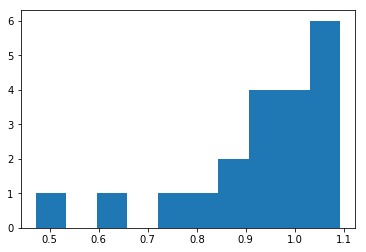

In [590]:
H=[]
for i in range(K):
    H.append(calc_entropy(all_labels,i=i,j=i+1)[0])

hist(H);

In [591]:
cumH=np.concatenate([np.zeros(1),cumsum(H)])
cumH

array([ 0.        ,  0.93618045,  1.98026403,  2.96898695,  4.00066787,
        4.86069284,  5.88142457,  6.83551614,  7.66221967,  8.30271346,
        8.77429604,  9.55267715, 10.5756932 , 11.42077568, 12.47250512,
       13.39324949, 14.32797381, 15.30119304, 16.39370903, 17.48518438,
       18.55835664])

In [592]:
HC=[]
counts_vecs=[]
for i in range(K):
    H,counts,c=calc_entropy(all_labels,i=0,j=i)
    HC.append(H)
    counts_vecs.append(counts)

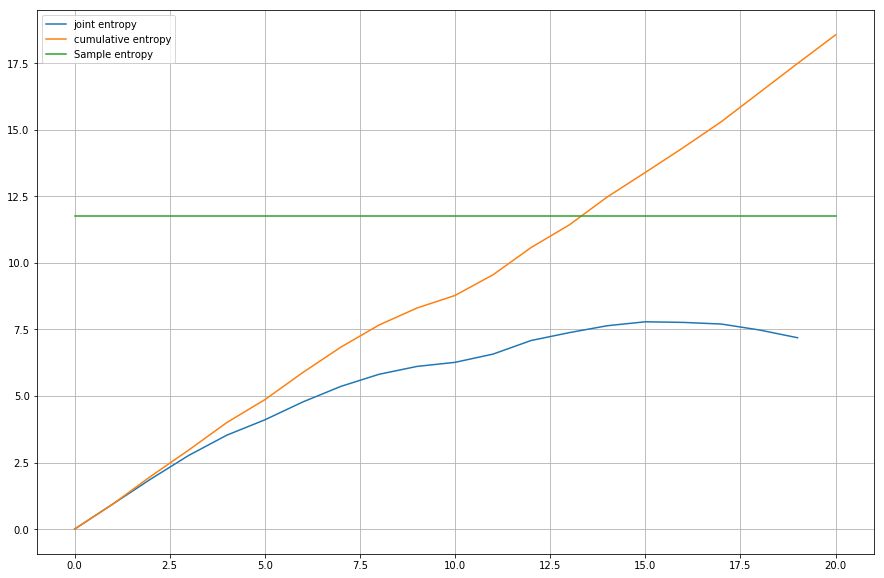

In [593]:
figure(figsize=[15,10])
j=K+1
plot(HC[:j],label='joint entropy')
plot(cumH[:j],label='cumulative entropy')
sample_H = log(len(all_labels))
plot([sample_H]*j,label='Sample entropy')
grid()
legend()

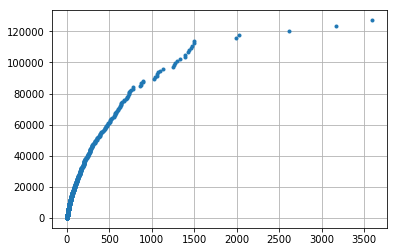

In [597]:
K1=8
H,counts,c=calc_entropy(all_labels,i=0,j=K1)

sc=sort(counts)
plot(sc,cumsum(sc),'.');
grid()

In [598]:
sc[-20:]

array([1090., 1134., 1243., 1256., 1268., 1294., 1325., 1386., 1388.,
       1425., 1437., 1466., 1470., 1492., 1497., 1994., 2021., 2616.,
       3169., 3586.])

In [599]:
size=1000
core_sets={x[0]:[] for x in c.items() if x[1]>size}
core_sets

{(0, 0, 0, 2, 0, 0, 0, 1): [],
 (0, 0, 0, 2, 2, 0, 0, 1): [],
 (0, 1, 2, 0, 0, 1, 0, 0): [],
 (0, 2, 0, 0, 0, 0, 0, 1): [],
 (0, 2, 0, 0, 1, 0, 0, 1): [],
 (0, 2, 0, 0, 2, 0, 0, 1): [],
 (0, 2, 0, 2, 0, 0, 0, 1): [],
 (0, 2, 0, 2, 1, 0, 0, 1): [],
 (0, 2, 0, 2, 2, 0, 0, 1): [],
 (0, 2, 1, 0, 0, 1, 0, 1): [],
 (0, 2, 2, 0, 0, 1, 0, 0): [],
 (0, 2, 2, 0, 0, 1, 2, 0): [],
 (1, 0, 0, 2, 2, 0, 0, 1): [],
 (1, 0, 0, 2, 2, 0, 1, 1): [],
 (1, 1, 0, 0, 2, 0, 0, 0): [],
 (1, 1, 0, 0, 2, 0, 0, 1): [],
 (1, 1, 0, 0, 2, 1, 0, 0): [],
 (1, 1, 0, 1, 2, 2, 1, 0): [],
 (1, 1, 0, 1, 2, 2, 1, 1): [],
 (1, 1, 0, 2, 2, 0, 0, 1): [],
 (1, 1, 1, 1, 2, 1, 1, 0): [],
 (1, 1, 1, 1, 2, 1, 1, 1): [],
 (1, 1, 2, 0, 2, 1, 0, 0): [],
 (1, 2, 0, 0, 2, 0, 0, 1): [],
 (1, 2, 0, 2, 2, 0, 0, 1): []}

In [600]:
[x for x in c.items() if x[1]>size]

[((1, 1, 0, 0, 2, 1, 0, 0), 1243),
 ((0, 2, 1, 0, 0, 1, 0, 1), 1134),
 ((1, 1, 0, 2, 2, 0, 0, 1), 3586),
 ((1, 1, 0, 0, 2, 0, 0, 0), 1492),
 ((1, 1, 0, 1, 2, 2, 1, 0), 1256),
 ((1, 1, 2, 0, 2, 1, 0, 0), 1031),
 ((1, 0, 0, 2, 2, 0, 0, 1), 1994),
 ((1, 1, 0, 0, 2, 0, 0, 1), 2616),
 ((0, 2, 2, 0, 0, 1, 2, 0), 1497),
 ((1, 1, 0, 1, 2, 2, 1, 1), 1466),
 ((1, 2, 0, 0, 2, 0, 0, 1), 1325),
 ((1, 2, 0, 2, 2, 0, 0, 1), 1437),
 ((1, 1, 1, 1, 2, 1, 1, 0), 1425),
 ((0, 2, 0, 2, 2, 0, 0, 1), 1470),
 ((0, 2, 0, 2, 0, 0, 0, 1), 1055),
 ((0, 2, 0, 0, 0, 0, 0, 1), 3169),
 ((0, 2, 0, 2, 1, 0, 0, 1), 1071),
 ((1, 1, 1, 1, 2, 1, 1, 1), 1028),
 ((0, 1, 2, 0, 0, 1, 0, 0), 1057),
 ((0, 2, 0, 0, 2, 0, 0, 1), 1386),
 ((0, 2, 0, 0, 1, 0, 0, 1), 1388),
 ((0, 2, 2, 0, 0, 1, 0, 0), 1294),
 ((1, 0, 0, 2, 2, 0, 1, 1), 1268),
 ((0, 0, 0, 2, 0, 0, 0, 1), 1090),
 ((0, 0, 0, 2, 2, 0, 0, 1), 2021)]

In [605]:
lcombined.shape[0]/(3**8)

19.383173296753544

In [601]:
for i in range(len(all_labels)):
    vec=all_labels[i][:K1]
    if i%1000 == 0:
        print('\r',i,end='')
    if vec in core_sets:
        core_sets[vec].append(i)
        #print(vec,core_sets[vec])

 127000

In [602]:
len(all_labels),lcombined.shape

(127173, (127173, 21, 21))

(0, 2, 2, 0, 0, 1, 0, 0) (1294, 21, 21)
(0, 1, 2, 0, 0, 1, 0, 0) (1057, 21, 21)
(1, 1, 0, 0, 2, 1, 0, 0) (1243, 21, 21)
(1, 1, 0, 0, 2, 0, 0, 1) (2616, 21, 21)
(1, 1, 0, 1, 2, 2, 1, 0) (1256, 21, 21)
(0, 2, 0, 2, 2, 0, 0, 1) (1470, 21, 21)
(1, 0, 0, 2, 2, 0, 0, 1) (1994, 21, 21)
(0, 0, 0, 2, 0, 0, 0, 1) (1090, 21, 21)
(1, 2, 0, 0, 2, 0, 0, 1) (1325, 21, 21)
(1, 0, 0, 2, 2, 0, 1, 1) (1268, 21, 21)
(0, 2, 1, 0, 0, 1, 0, 1) (1134, 21, 21)
(1, 1, 0, 2, 2, 0, 0, 1) (3586, 21, 21)
(1, 1, 1, 1, 2, 1, 1, 1) (1028, 21, 21)
(1, 1, 2, 0, 2, 1, 0, 0) (1031, 21, 21)
(1, 1, 0, 0, 2, 0, 0, 0) (1492, 21, 21)
(0, 2, 0, 0, 0, 0, 0, 1) (3169, 21, 21)
(0, 2, 0, 2, 0, 0, 0, 1) (1055, 21, 21)
(1, 1, 0, 1, 2, 2, 1, 1) (1466, 21, 21)
(0, 0, 0, 2, 2, 0, 0, 1) (2021, 21, 21)
(0, 2, 0, 0, 1, 0, 0, 1) (1388, 21, 21)
(0, 2, 2, 0, 0, 1, 2, 0) (1497, 21, 21)


/usr/local/lib/python3.5/dist-packages/matplotlib/pyplot.py:522: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  max_open_warning, RuntimeWarning)


(0, 2, 0, 2, 1, 0, 0, 1) (1071, 21, 21)
(1, 2, 0, 2, 2, 0, 0, 1) (1437, 21, 21)
(0, 2, 0, 0, 2, 0, 0, 1) (1386, 21, 21)
(1, 1, 1, 1, 2, 1, 1, 0) (1425, 21, 21)


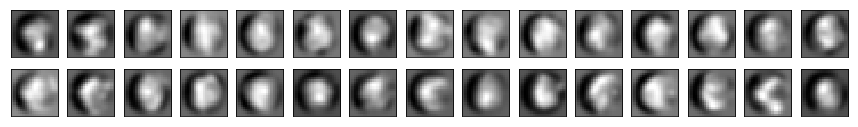

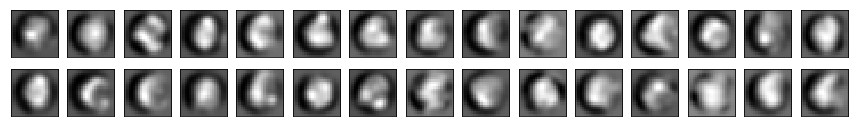

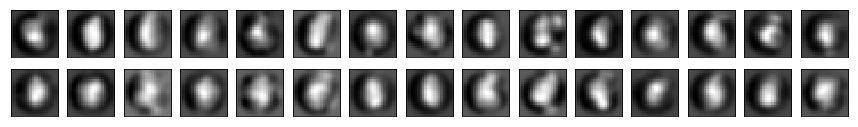

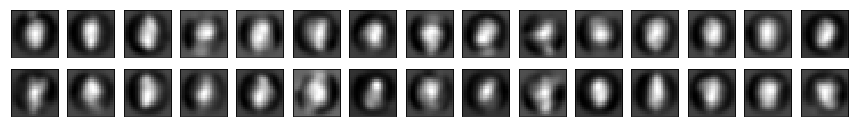

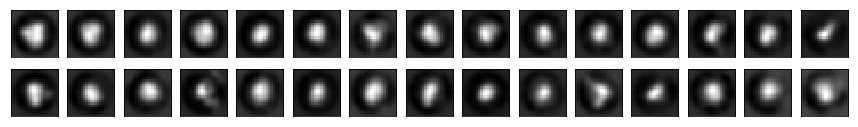

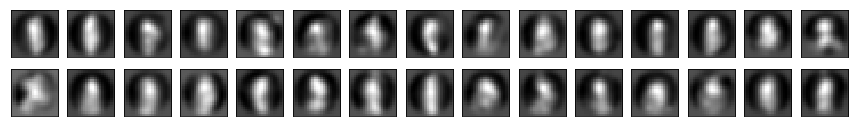

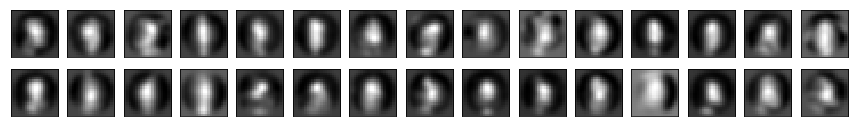

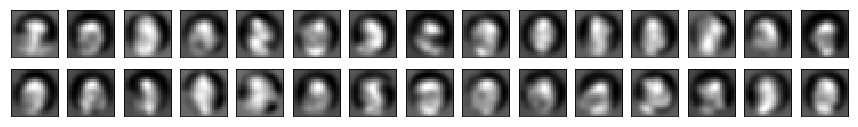

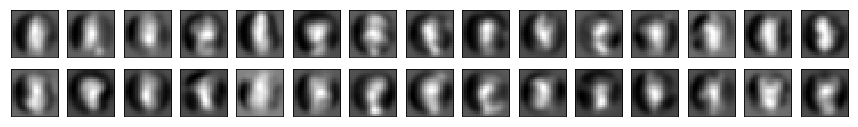

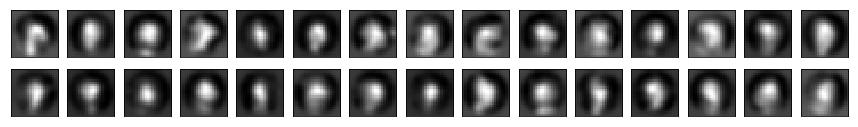

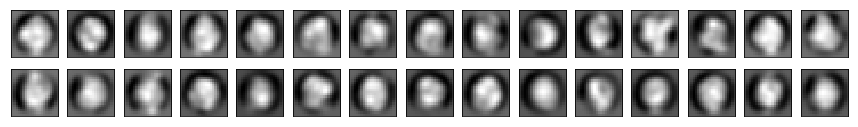

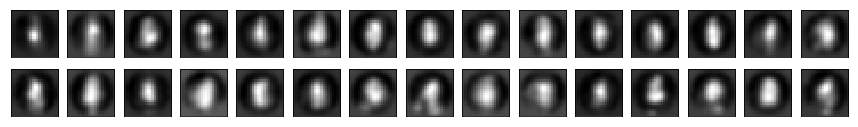

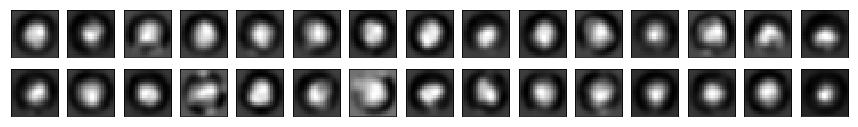

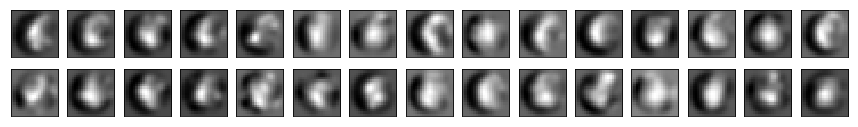

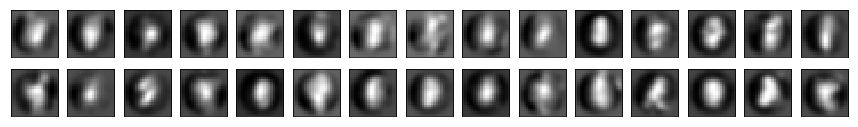

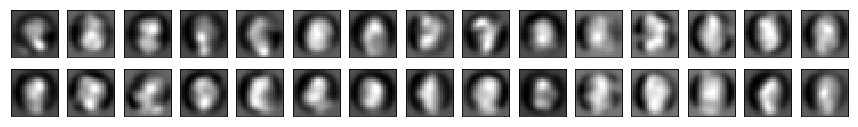

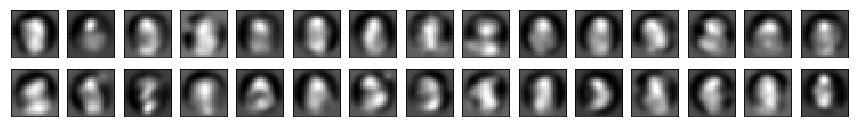

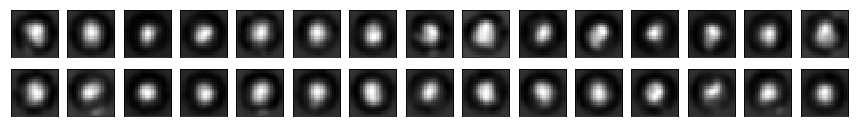

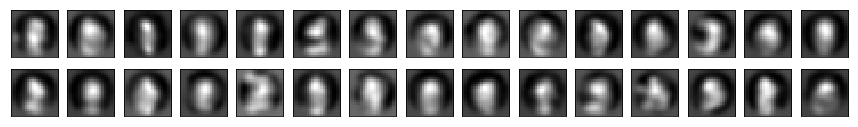

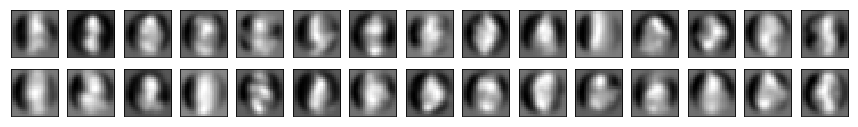

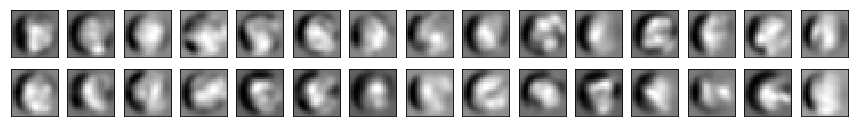

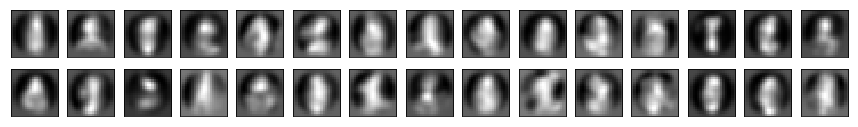

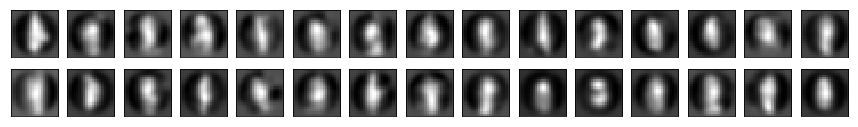

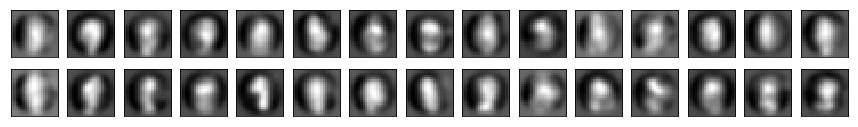

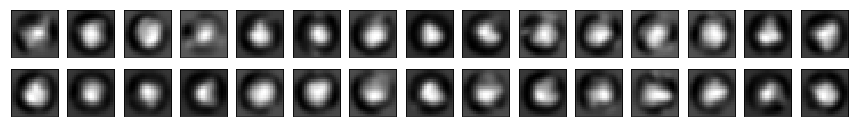

In [603]:
for key in core_sets.keys():
    data=lcombined[core_sets[key],:,:]
    print(key,data.shape)
    plot_patches(data,h=2)

## finding neighborhoods in the coding graph

In [567]:
len(c)

2274

In [580]:
cells=list(c.items())
cells=sorted(cells,key=lambda x:x[1],reverse=True)
cells[:10]

[((3, 1, 6, 5), 6041),
 ((8, 3, 1, 3), 5033),
 ((8, 3, 6, 3), 4730),
 ((6, 3, 6, 3), 3925),
 ((1, 1, 5, 6), 3368),
 ((1, 1, 6, 5), 2889),
 ((1, 1, 5, 5), 2436),
 ((3, 7, 6, 5), 2231),
 ((6, 1, 6, 3), 2176),
 ((1, 1, 5, 8), 2099)]

In [617]:
neighborhoods=[]

def hamming(a,b):
    assert len(a)==len(b)
    d=0
    for i in range(len(a)):
        if a[i]!=b[i]:
            d+=1
    return d

for i in range(len(cells)):
    key=cells[i][0]
    added=False
    for neigh in neighborhoods:
        for e in neigh:
            if hamming(e[0],key)<2:
                neigh.append(cells[i])
                added=True
                break
        if added:
            break
    if not added:
        neighborhoods.append([cells[i]])
            
            
    

In [618]:
len(neighborhoods)

13

In [624]:
for i in range(len(neighborhoods)):
    total=sum([x[1] for x in neighborhoods[i]])
    print(neighborhoods[i][0],total)

((3, 1, 6, 5), 6041) 78505
((8, 3, 1, 3), 5033) 27869
((1, 1, 5, 6), 3368) 12775
((4, 9, 2, 2), 1493) 2052
((4, 1, 0, 1), 1008) 2211
((0, 0, 1, 3), 863) 1543
((3, 9, 2, 0), 582) 582
((9, 1, 0, 9), 437) 618
((0, 7, 9, 0), 206) 206
((5, 2, 8, 3), 175) 687
((9, 2, 8, 9), 120) 120
((7, 8, 4, 5), 2) 4
((7, 7, 4, 4), 1) 1
